In [72]:
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.dates as mdates

# open file /run/secrets/postgres_pwd
with open(os.getenv("POSTGRES_PASSWORD_FILE"), 'r') as file:
    password = file.read().strip()

# Connect to your postgres DB
def run_query(query):
    with psycopg2.connect(
        host="postgres",      # or IP address
        port=5432,             # default postgres port
        database=os.getenv("POSTGRES_DB"),
        user=os.getenv("POSTGRES_USER"),
        password="mysecretpassword") as conn:
            return pd.read_sql_query(query, conn)

In [73]:
sql = """
SELECT 
	event_time::date AS date, 
	count(DISTINCT user_id) AS user_purchase
FROM customers
WHERE event_type='purchase' AND (event_time::date BETWEEN '2022-10-01' AND '2023-02-28')
GROUP BY date
ORDER BY date;
"""
df = run_query(sql)
df = df.set_index('date')

/tmp/ipykernel_78482/1694171046.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


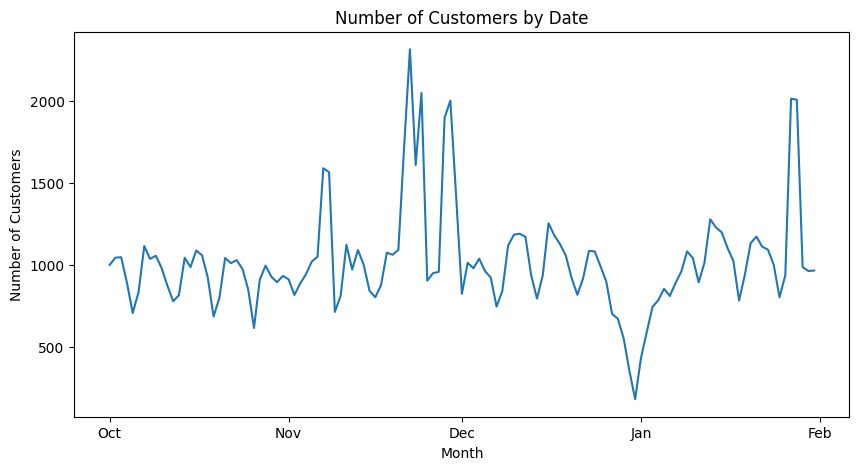

In [74]:
# plot line chart
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['user_purchase'])
plt.title('Number of Customers by Date')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()


In [75]:
sql = """
SELECT 
    DATE_TRUNC('month', event_time) AS order_month, 
    SUM(price) AS total_price
FROM customers
WHERE event_type='purchase'
GROUP BY DATE_TRUNC('month', event_time);
"""
df = run_query(sql)

/tmp/ipykernel_78482/1694171046.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


In [76]:
df.set_index('order_month', inplace=True)
df

,total_price
order_month,
2022-10-01 00:00:00+00:00,1211538.43
2022-11-01 00:00:00+00:00,1531016.90
2022-12-01 00:00:00+00:00,1077624.85
2023-01-01 00:00:00+00:00,1321535.48


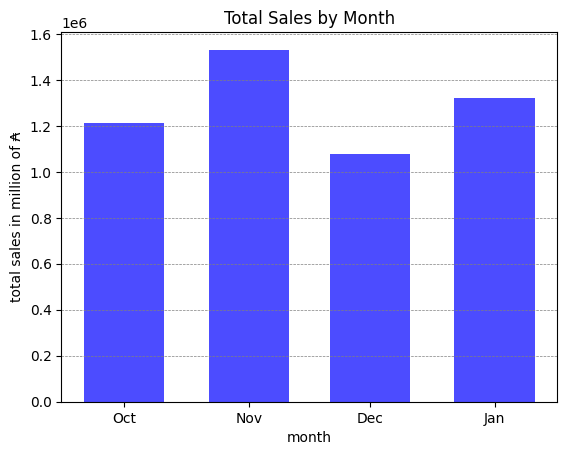

In [77]:
# plot bar chart
fig, ax = plt.subplots()
# ₳ is the currency symbol for the Argentine peso
# A$ is the currency symbol for the Australian dollar
# le6 is 10^6 (million)
ax.set_title('Total Sales by Month')
ax.grid(axis='y', which='major', color='gray', linestyle='--', linewidth=0.5)
ax.bar(df.index, df['total_price'], width=20, color='blue', alpha=0.7)
ax.set_ylabel('total sales in million of ₳')
ax.set_xlabel('month')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show()

In [78]:
sql = """
SELECT 
    event_time::date AS date,
    SUM(price) / COUNT(DISTINCT user_id) AS avg
FROM customers
WHERE event_type='purchase'
GROUP BY event_time::date;
"""
df = run_query(sql)
df.set_index('date', inplace=True)

/tmp/ipykernel_78482/1694171046.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


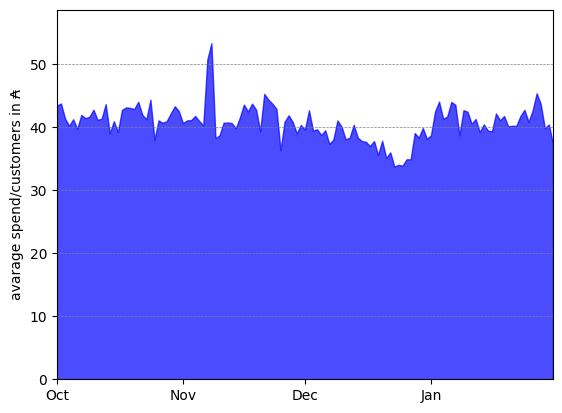

In [79]:
# plot area chart
fig, ax = plt.subplots()
# ax.set_title('Total Sales by Date')
ax.grid(axis='y', which='major', color='gray', linestyle='--', linewidth=0.5)
ax.fill_between(df.index, df['avg'], color='blue', alpha=0.7)
ax.set_ylabel('avarage spend/customers in ₳')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# set beginning x, y axis to 0
ax.set_xlim(df.index[0], df.index[-1])
ax.set_ylim(0, df['avg'].max() * 1.1)
plt.show()